In [1]:
# install opencv
!pip install opencv-python

import numpy as np
import cv2
import matplotlib.pyplot as plt

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
def video2array(pathname):
    cap = cv2.VideoCapture(pathname)
    success,image = cap.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # video = gray
    video = cv2.rotate(gray, cv2.ROTATE_180) # this video is upside down for some reason

    # plt.imshow(video)

    scale_percent = 40 # percent of original size
    width = int(video.shape[1] * scale_percent / 100)
    height = int(video.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    video = cv2.resize(video, dim, interpolation = cv2.INTER_AREA)

    while success:
        success, image = cap.read()
        if success:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.rotate(gray, cv2.ROTATE_180) 
            video = np.dstack((video, cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)))

    video = np.float32(video)/255
    return video

In [23]:
# Convert video to array

cap = cv2.VideoCapture('./resources_unzipped/shadow2.MOV')
success,image = cap.read()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# video = gray
video = cv2.rotate(gray, cv2.ROTATE_180) # this video is upside down for some reason

# plt.imshow(video)

scale_percent = 40 # percent of original size
width = int(video.shape[1] * scale_percent / 100)
height = int(video.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
video = cv2.resize(video, dim, interpolation = cv2.INTER_AREA)

while success:
    success, image = cap.read()
    if success:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.rotate(gray, cv2.ROTATE_180) 
        video = np.dstack((video, cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)))

video = np.float32(video)/255
print(video.shape)

(432, 768, 290)


In [4]:
# plt.imshow(video[:,:,200], cmap='gray')

In [5]:
XSIZE = video.shape[1]
YSIZE = video.shape[0]

def mylineplot(**kwargs):
    
    # if no axes object provided, create new figure and axes
    if 'axes' in kwargs:
        ax=kwargs.get("axes")
        fig=ax.figure
    else:
        fig, ax = plt.subplots(figsize=(6,6))
        
        # make axes "image-like", with origin (0,0) in the top-left corner
        ax.set_aspect(aspect=1)
        ax.set_xlim([0, XSIZE])
        ax.set_ylim([0, YSIZE])
        ax.invert_yaxis()
        ax.xaxis.tick_top()
    
    # plot points
    if 'points' in kwargs:
        pts=kwargs.get("points")
        ax.plot(pts[:, 0], pts[:, 1], 'b.')
    
    # plot line using zero-value contour of h(x,y)=ax+by+c
    if 'line' in kwargs:
        line=kwargs.get("line")
        x,y=np.meshgrid(np.linspace(0,XSIZE,YSIZE*5),np.linspace(0,XSIZE,YSIZE*5))
        ax.contour(x, y, line[0]*x+line[1]*y+line[2], [0], colors='r')
    
    return fig,ax

In [6]:
# front_edge_times -- HxW array with each element storing the time (in units of frame number) 
# at which the leading shadow edge crosses that pixel.
# Optionally, a second HxW array with each element storing the time (in units of frame number) 
# at which the trailing shadow edge crosses that pixel.
# Entries in these arrays that are NaN or (-1) indicate that no shadow edge was detected at the pixel.
#
# Input: H x W x T video array

def get_front_edge_times(video):
    biggest = np.max(video, axis=2)
    smallest = np.min(video, axis=2)
    norm = biggest/2 + smallest/2

    video_norm = video - norm[:,:,np.newaxis]

    signs = np.sign(video_norm)
    shadows = np.argmin(signs, axis=2)
    
    front_edge_times = np.where(shadows < 10, -1, shadows)
    
    return front_edge_times

In [69]:
# image_lines -- length-T list of 2x3 arrays. 
# The ith 2x3 array contains the homogeneous coordinates of the two image lines (as rows) 
# on the horizontal and vertical planes in the ith video frame.
#
# Input: front_edge_times

def get_image_lines(front_edge_times, mask_top, mask_bottom, T):
    image_lines = []
    
    for t in range(T):
        # top line:
        top_board = np.zeros_like(front_edge_times)
        top_board = np.where(front_edge_times == t, 1, top_board)
        top_board = np.where(mask_top == 0, 0, top_board)
        
        y,x = np.nonzero(top_board)
        X = np.vstack((x,y)).T
        A = in2hom(X)
        U,D,VT = np.linalg.svd(A)
        l_top = VT[-1,]
        
        # bottom line:
        bottom_board = np.zeros_like(front_edge_times)
        bottom_board = np.where(front_edge_times == t, 1, bottom_board)
        bottom_board = np.where(mask_bottom == 0, 0, bottom_board)
        
        y,x = np.nonzero(bottom_board)
        X = np.vstack((x,y)).T
        A = in2hom(X)
        U,D,VT = np.linalg.svd(A)
        l_bottom = VT[-1,]
        
        image_lines.append(np.vstack((l_top, l_bottom)))
    
    return image_lines

[-0.67263117  1.         91.70577733]


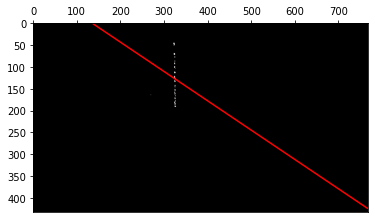

In [40]:
T = 195

f = get_front_edge_times(video)

top_board = np.zeros_like(f)
top_board = np.where(f == T, 1, top_board)
top_board = np.where(mask_top == 0, 0, top_board)


y,x = np.nonzero(top_board)
A = np.vstack((x,np.ones_like(x))).T
b = -np.array(y).T
u = np.linalg.lstsq(A, b, rcond=None)[0]
l_top = np.array([u[0], 1, u[1]])

print(l_top)

f,ax = mylineplot(line=l_top)
ax.imshow(top_board, cmap='gray')

In [52]:
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

In [61]:
y,x = np.nonzero(top_board)
print(np.vstack((x,y)).T)
# print(np.concatenate([x, y]))

[[375  58]
 [375  59]
 [376  59]
 [377  59]
 [375  60]
 [376  60]
 [377  60]
 [378  60]
 [375  61]
 [376  61]
 [377  61]
 [378  61]
 [375  62]
 [376  62]
 [377  62]
 [375  63]
 [376  63]
 [377  63]
 [378  63]
 [375  64]
 [376  64]
 [377  64]
 [374  65]
 [375  65]
 [376  65]
 [377  65]
 [374  66]
 [375  66]
 [376  66]
 [377  66]
 [374  67]
 [375  67]
 [376  67]
 [377  67]
 [375  68]
 [376  68]
 [377  68]
 [375  69]
 [376  69]
 [377  69]
 [375  70]
 [376  70]
 [377  70]
 [375  71]
 [376  71]
 [377  71]
 [375  72]
 [376  72]
 [377  72]
 [375  73]
 [376  73]
 [377  73]
 [375  74]
 [376  74]
 [377  74]
 [375  75]
 [376  75]
 [375  76]
 [376  76]
 [375  77]
 [376  77]
 [375  78]
 [376  78]
 [375  79]
 [376  79]
 [375  80]
 [376  80]
 [375  81]
 [376  81]
 [375  82]
 [376  82]
 [375  83]
 [376  83]
 [377  83]
 [375  84]
 [376  84]
 [377  84]
 [378  84]
 [375  85]
 [376  85]
 [377  85]
 [378  85]
 [375  86]
 [376  86]
 [377  86]
 [378  86]
 [375  87]
 [376  87]
 [377  87]
 [378  87]
 [375  88]

[-2.66095178e-03  1.46309827e-05  9.99996460e-01]


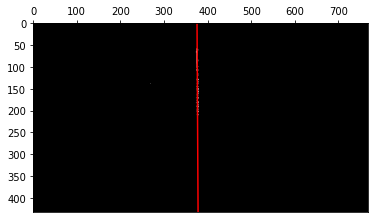

In [62]:
T = 180

f = get_front_edge_times(video)

top_board = np.zeros_like(f)
top_board = np.where(f == T, 1, top_board)
top_board = np.where(mask_top == 0, 0, top_board)


y,x = np.nonzero(top_board)
X = np.vstack((x,y)).T
A = in2hom(X)
U,D,VT = np.linalg.svd(A)
l_top = VT[-1,]

# A = np.vstack((x,np.ones_like(x))).T
# b = -np.array(y).T
# u = np.linalg.lstsq(A, b, rcond=None)[0]
# l_top = np.array([u[0], 0, u[1]])
# # l_top = np.array([u[0], u[1], 1])

print(l_top)

f,ax = mylineplot(line=l_top)
ax.imshow(top_board, cmap='gray')

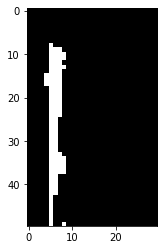

In [38]:
plt.imshow(top_board[50:100, 370:400], cmap="gray")

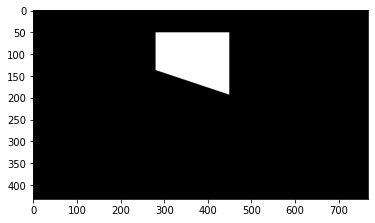

In [8]:
mask_top = np.zeros_like(get_front_edge_times(video))
for x in range(432):
    for y in range(768):
        if (y > 3*x-130 and y > 280 and y < 450 and x > 50):
            mask_top[x][y]=1
        
plt.imshow(mask_top, cmap='gray')

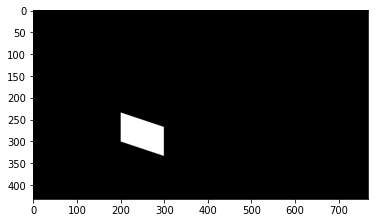

In [9]:
mask_bottom = np.zeros_like(get_front_edge_times(video))
for x in range(432):
    for y in range(768):
        if (y < 3*x-500 and y > 200 and y < 300 and y > 3*x-700):
            mask_bottom[x][y]=1
        
plt.imshow(mask_bottom, cmap='gray')

In [70]:
image_lines = get_image_lines(get_front_edge_times(video), mask_top, mask_bottom, video.shape[2])

(0.0, 768.0, 432.0, 0.0)

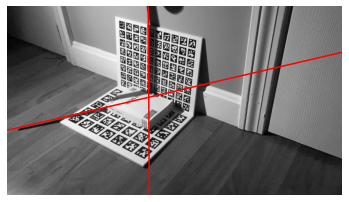

In [71]:
T = 195 # this is the best-looking time, because the masks are not very good

f,ax = mylineplot(line=image_lines[T][0])
mylineplot(line=image_lines[T][1], axes=ax)
ax.imshow(video[:,:,T],cmap="gray")
ax.axis('off')

[ 2.42371007e-03 -1.08402632e-05 -9.99997063e-01]
[ 5.03824279e-04  3.24589695e-03 -9.99994605e-01]


(0.0, 768.0, 432.0, 0.0)

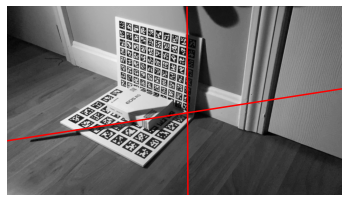

In [72]:
T2 = 170 # this is the best-looking time, because the masks are not very good
print(image_lines[T2][0])
print(image_lines[T2][1])
f,ax = mylineplot(line=image_lines[T2][0])
mylineplot(line=image_lines[T2][1], axes=ax)
ax.imshow(video[:,:,T2],cmap="gray")
ax.axis('off')

In [12]:
def processVideo(video_pathname, mask_top, mask_bottom):
    video = video2array(video_pathname)
    front_edge_times = get_front_edge_times(video)
    image_lines = get_image_lines(front_edge_times, mask_top, mask_bottom, video.shape[2])
    return front_edge_times, image_lines

(432, 768)


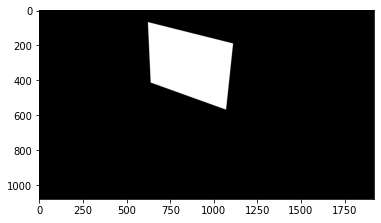

In [31]:
mask_top = cv2.imread('./resources_unzipped/mask_top.png')
plt.imshow(mask_top)

scale_percent = 40 # percent of original size
width = int(mask_top.shape[1] * scale_percent / 100)
height = int(mask_top.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
mask_top = cv2.resize(mask_top, dim, interpolation = cv2.INTER_AREA)
mask_top = cv2.cvtColor(mask_top, cv2.COLOR_BGR2GRAY)

print(mask_top.shape)

In [ ]:
# # get H x W x T (time) video file as array

# cap = cv2.VideoCapture('./resources_unzipped/shadow.MOV')
# success,image = cap.read()
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# video = gray

# scale_percent = 40 # percent of original size
# width = int(video.shape[1] * scale_percent / 100)
# height = int(video.shape[0] * scale_percent / 100)
# dim = (width, height)
# # resize image
# video = cv2.resize(video, dim, interpolation = cv2.INTER_AREA)

# while success:
#     success, image = cap.read()
#     if success:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         video = np.dstack((video, cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)))

# video = np.float32(video)/255
# print(video.shape)

In [ ]:
# def video2array(pathname, res):
#     cap = cv2.VideoCapture(pathname)
#     success, image = cap.read()
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     array = gray

#     scale = res/video.shape[1] # percent of original size
#     width = int(video.shape[1] * scale)
#     height = int(video.shape[0] * scale)
#     dim = (width, height)
#     # resize image
#     video = cv2.resize(video, dim, interpolation = cv2.INTER_AREA)

#     while success:
#         success, image = cap.read()
#         if success:
#             gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             array = np.dstack((array, cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)))
    
#     array = np.float32(array)/255

#     return array

In [ ]:
# # given a list, find the first time it goes below the mean of the list
# def front_edge_helper(lst):
#     biggest = np.max(lst)
#     smallest = np.min(lst)
#     if (biggest == smallest):
#         return -1
#     return list(map(lambda i: i < (biggest/2 + smallest/2), lst)).index(True) 

# print(front_edge_helper([5,5,5,5,5,5,5]))
# print(front_edge_helper([5,5,5,5,0,5,5]))

In [ ]:
# test = np.array([[0,0,0],[1,1,1],[2,2,2]])
# test2 = np.dstack((test, 2*test))
# print(test)
# print(test2.shape)

# print(np.max(test2, axis=2))

# print(np.apply_along_axis(np.max, 2, test2))
# print(np.apply_along_axis(np.min, 2, test2))
# biggest = np.max(test2, axis=2)
# smallest = np.min(test2, axis=2)
# norm = biggest/2 + smallest/2
# print(norm)
# test_norm = test2-norm[:,:,np.newaxis]
# print(test_norm[:,:,0])


# x = np.apply_along_axis(np.sign, 2, test_norm)
# print(np.apply_along_axis(np.argmin, 2, x))
# # print(np.apply_along_axis(np.sign, 2, test_norm))

In [ ]:
print(type(video))

In [ ]:
# biggest = np.max(video, axis=2)
# smallest = np.min(video, axis=2)
# norm = biggest/2 + smallest/2

# video_norm = video - norm[:,:,np.newaxis]

# # print(type(video_norm))

# signs = np.sign(video_norm)
# shadows = np.argmin(signs, axis=2)

# print(shadows.shape)

In [ ]:
# print(shadows.shape)

In [ ]:
# print(shadows)

In [ ]:
# print(video_norm[0,-1,:])

In [ ]:
# plt.plot(video_norm[0,-1,:])
# plt.show()

In [ ]:
# plt.imshow(biggest, cmap='gray')

In [ ]:
# plt.imshow(smallest, cmap='gray')

In [ ]:
# img = cv2.imread('./resources_unzipped/bitmap_mask_3.jpg')

# scale_percent = 40 # percent of original size
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)
# # resize image
# img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# plt.imshow(img)

In [ ]:
# front_edge_times = np.where(img == 0, -1, shadows)
# print(front_edge_times)

In [ ]:
# # front_edge_times -- HxW array with each element storing the time (in units of frame number) 
# # at which the leading shadow edge crosses that pixel.



# front_edge_times = np.apply_along_axis(front_edge_helper, 2, video)

In [ ]:
# image_lines -- length-T list of 2x3 arrays. The ith 2x3 array contains the homogeneous coordinates of 
# the two image lines (as rows) on the horizontal and vertical planes in the ith video frame.


In [ ]:
mask_top